In [1]:
import umap
import cv2
import torch 
import os
import swat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import defaultdict
from PIL import Image

### Read data and visualise a few examples

In [3]:
root = 'data/images'
labels_path = 'data/gicsd_labels.csv'
data = pd.read_csv(labels_path)

Sinse the dataset is small we can load all the data in the memory

In [4]:
all_image_files = [ datum['IMAGE_FILENAME'] for index, datum in data.iterrows()]
all_image_labels = [datum[' LABEL'] for index, datum in data.iterrows()]


all_images = [cv2.imread(os.path.join(root,file)) for file in all_image_files]

Check if all the images are the same size

In [5]:
image_shapes = set([image.shape for image in all_images])
print(image_shapes)

{(192, 192, 3)}


Reorganise the data into dictionary by the label

In [6]:
data_dict = defaultdict(list)
for index, datum in data.iterrows():
    data_dict[datum[' LABEL']].append(os.path.join(root, datum['IMAGE_FILENAME'])) 

In [7]:
for key, images in data_dict.items():
    print(key, len(images))

 FULL_VISIBILITY  646
 PARTIAL_VISIBILITY  123
 NO_VISIBILITY  31


The dataset is highly unballanced with 'NO_VISIBILITY' class having 20 times less images than the 'FULL_VISIBILITY'.  
There are several ways to overcome the disbalance in the data classes: 
1. Add more data. 
    - Find examples of the tables(and other surfaces) without an ids on it. 
2. Oversample with synthetic data:
   - Crop the images of the so they don't have the ids in them \n
   - Rotate the images without ids in them 
   - Use GAN to generate more examples for the less prevalent classes
3. Undersample the more prevalent class

### Visualise a few examples

 FULL_VISIBILITY 


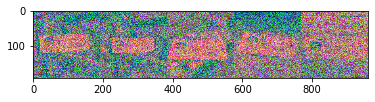

 PARTIAL_VISIBILITY 


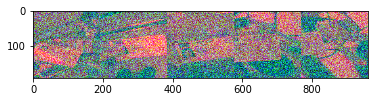

 NO_VISIBILITY 


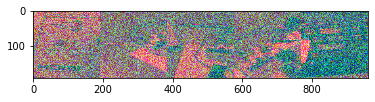

In [8]:
for key, images in data_dict.items():
    frames = [cv2.imread(im) for im in images[:5]]
    print(key)
    plt.imshow(np.asarray(np.hstack(frames)))
    plt.show()

The images seem to be noisy and not colour balances. To check that we can look at the colour histogram of one of agew images 

 FULL_VISIBILITY 


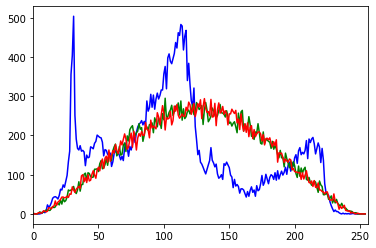

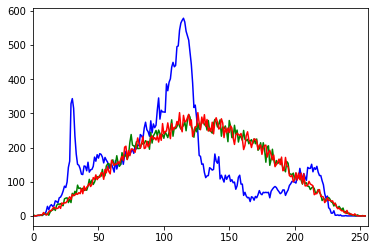

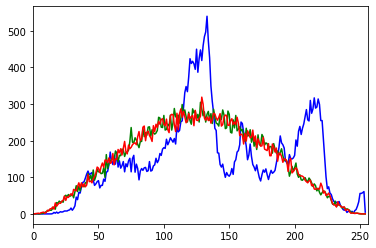

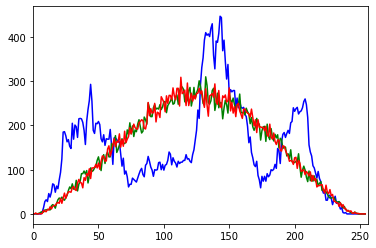

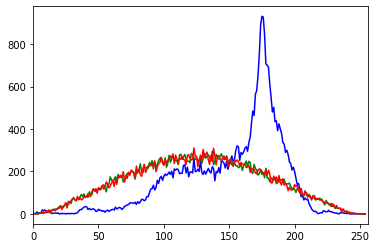

 PARTIAL_VISIBILITY 


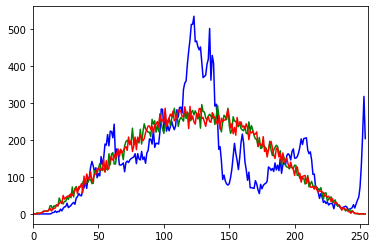

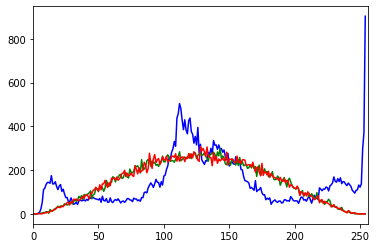

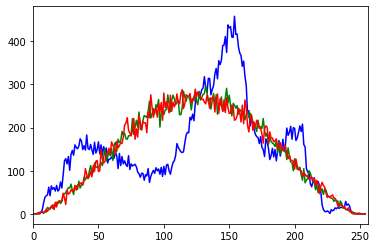

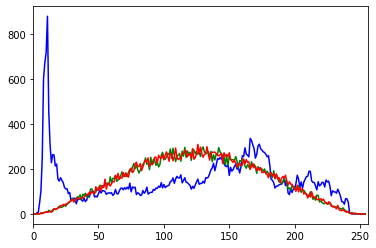

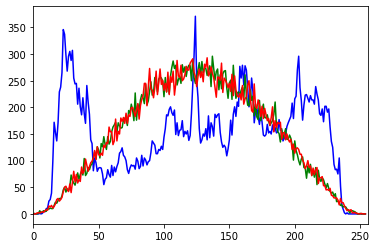

 NO_VISIBILITY 


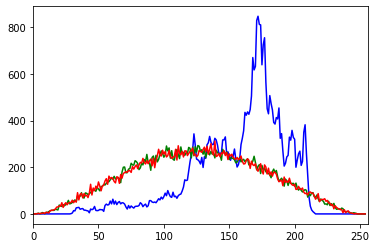

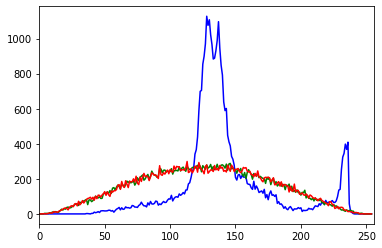

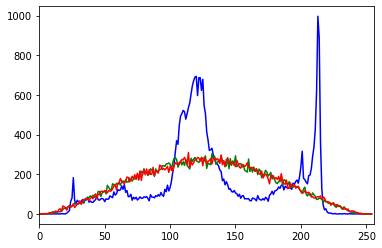

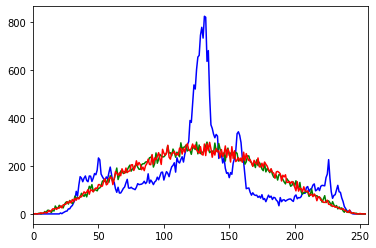

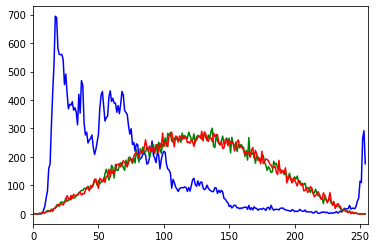

In [9]:
colours = ['b','g','r'] 

for key, images in data_dict.items():
    print(key)
    frames = [cv2.imread(im) for im in images[:5]]
    for frame in frames: 
        chans = cv2.split(frame)
        for (chan, color) in zip(chans, colours):   
            hist = cv2.calcHist([chan],[0], None, [255], [0, 256])
            plt.plot(hist, color = color)
            plt.xlim([0, 256])
        plt.show()

The colour histogram indicates that all the image information is stored in the blue channel (#0 in BGR), while channels green and red (1 and 2) only have Gaussian noise.   
To confirm that we can display each of the channels separately:

 FULL_VISIBILITY 


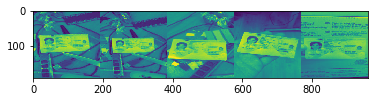

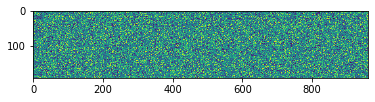

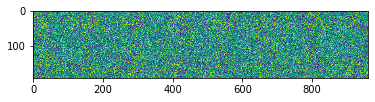

 PARTIAL_VISIBILITY 


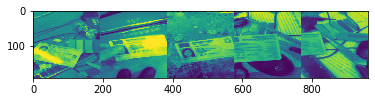

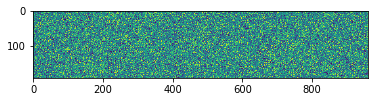

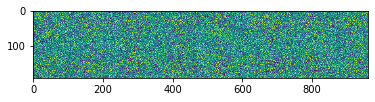

 NO_VISIBILITY 


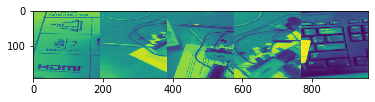

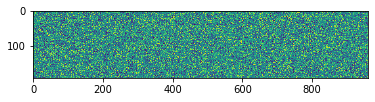

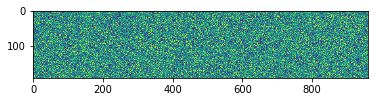

In [10]:
for key, images in data_dict.items():
    frames = [cv2.imread(im) for im in images[:5]]
    blues = [frame[:,:,0] for frame in frames]
    greens = [frame[:,:,1] for frame in frames]
    reds = [frame[:,:,2] for frame in frames]


    print(key)
    plt.imshow(np.asarray(np.hstack(blues)))
    plt.show()
    plt.imshow(np.asarray(np.hstack(greens)))
    plt.show()
    plt.imshow(np.asarray(np.hstack(reds)))
    plt.show()

### Save the blue channel of the data as greyscale images in the folder data/images_grayscale

In [11]:
new_root = 'data/images_grayscale'
os.makedirs(new_root, exist_ok=True)
all_images = [im[:,:,0] for im in all_images]
for im, filename in zip(all_images, all_image_files):
    cv2.imwrite(os.path.join(new_root, filename), im)

*b)* Create a function that transforms an image (in the format of a numpy array) into a single-channel image.
The data is in the blue channel, therefore if an image is read in RGB the data is going to be in the 2nd channel. To avoid that ambiguity i add a function that reads the data as BGR

In [12]:
def grayscale_channel(img_path):
    img = cv2.imread(img_path) 
    return img[:,:,0]

### Split the data into training, testing and validation dataset: 
Since the data is unbalanced, we have to take care and make sure that the testing set still has enough examples of the underrepresented class to assess the performance of the model: 

For the test set I have decided to choose 10% for classes FULL_VISIBILITY and PARTIAL_VISIBILITY and 10 images for the class NO_VISIBILITY: 
 
 FULL_VISIBILITY  64  
 PARTIAL_VISIBILITY  12  
 NO_VISIBILITY  10
 
 In the real world situation, I would opt out for getting more examples of the NO_VISIBILITY class from either original MIDV-500 dataset or scraping the internet for the images of tables, desks and other surfaces. Still, as data labelling and scrapping can take a long time I've decited not to do it during this coding test.

In [13]:
data

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY
...,...,...
795,GICSD_50_7_213.png,NO_VISIBILITY
796,GICSD_50_7_233.png,PARTIAL_VISIBILITY
797,GICSD_50_8_253.png,FULL_VISIBILITY
798,GICSD_50_9_273.png,FULL_VISIBILITY


In [14]:
# Split dataframe by label and shuffle it
data_fv= data[data[' LABEL']==' FULL_VISIBILITY '].reset_index(drop=True)
data_pv= data[data[" LABEL"]==' PARTIAL_VISIBILITY '].reset_index(drop=True)
data_nc= data[data[" LABEL"]==' NO_VISIBILITY '].reset_index(drop=True)

test = data_fv.loc[:int(len(data_fv)*.1),:]
test = test.append(data_pv.loc[:int(len(data_pv)*.1),:], ignore_index=True)
test = test.append(data_nc.loc[:9,:], ignore_index=True)
test.to_csv('data/gicsd_labels_test.csv')

data_fv = data_fv.loc[int(len(data_fv)*.1)+1:,:]
data_pv = data_pv.loc[int(len(data_pv)*.1)+1:,:]
data_nc = data_nc.loc[10:,:]

print(test.shape)
print(data_fv.shape)
print(data_pv.shape)
print(data_nc.shape)

(88, 2)
(581, 2)
(110, 2)
(21, 2)


In [15]:
data_pv

,IMAGE_FILENAME,LABEL
13,GICSD_7_6_193.png,PARTIAL_VISIBILITY
14,GICSD_7_7_213.png,PARTIAL_VISIBILITY
15,GICSD_8_3_93.png,PARTIAL_VISIBILITY
16,GICSD_8_5_173.png,PARTIAL_VISIBILITY
17,GICSD_8_6_193.png,PARTIAL_VISIBILITY
...,...,...
118,GICSD_49_1_53.png,PARTIAL_VISIBILITY
119,GICSD_49_6_193.png,PARTIAL_VISIBILITY
120,GICSD_50_2_73.png,PARTIAL_VISIBILITY
121,GICSD_50_6_193.png,PARTIAL_VISIBILITY


### Augment data in preparation for training

In order to balance the classes in the training dataset I have decided to oversample the less prevalent classes with augmentations. Since the original dataset consists of images of the same id card taken with different angles and with different rotations I have chosen to *rotate* images as the augmentation that are done to the PARTIAL_VISIBILITY and NO_VISIBILITY classes in order to increase the number of examples on these classes. In addition for NO_VISIBILITY class I will add horisontal and vertical flip.

I have also considered cropping the images in the FULL_VISIBILITY class such that only part of the id card is visible or no id card is visible.

In [16]:
root = 'data/images_grayscale'
from utils import rotate_data, flip_data, mirror_data

Augment NO_VISIBILITY data

In [17]:
data_nc = rotate_data(data_nc, root)
data_nc = flip_data(data_nc, root)
data_nc = mirror_data(data_nc, root)
data_nc.to_csv('data/data_nc2.csv')

print(data_nc.shape)

(168, 2)


Augment PARTIAL_VISIBILITY data

In [18]:
data_pv = rotate_data(data_pv, root)
data_pv.to_csv('data/data_pv2.csv')


print(data_pv.shape)

(220, 2)


In [19]:
train = data_fv.append(data_pv, ignore_index=True)
train = train.append(data_nc, ignore_index=True).sample(frac=1).reset_index(drop=True)

validation = train.loc[:int(len(train)*.1),:]
train = train.loc[int(len(train)*.1)+1:,:]


train.to_csv('data/gicsd_labels_train.csv')
validation.to_csv('data/gicsd_labels_val.csv')

### Classifier
For the classifier I have decided to go with a ResNet34 as I couldn't train a deeper model on my personal computer that doesn't have a CUDA competible GPU. 

As a base I used a pretrained model from the pytorch model zoo and modyfied the first layer to take single layer image input 
```
(conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
```
and the fully connected layer to make it a 3 class classifyer: 
```
(fc): Linear(in_features=512, out_features=3, bias=True)
```
Since I have changed the first layer I had to leave the weights of the model unfrozen that undercut the benefits of transfer learning. One of ways of running models trained on RGB images with grayscale inputs is to pass the same grayscale image in all 3 channels of the model, but the challenge task has specified that the model has to take a single channel input.

In [31]:
from train import Model
from torchvision import transforms
from dataset import Dataset
model = Model()
print(model)

Model(
  (resnet): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

For the model training code and the details of the Model please refer to train.py  
Unfortunately, I didn't have an access to a GPU powered computer, so I couldn't train the model properly. Here I use the code below as a demonstration

In [40]:
checkpoint = torch.load('resnet34.pth')
model.load_state_dict(checkpoint['state_dict'])
all_labels = [' FULL_VISIBILITY ', ' PARTIAL_VISIBILITY ', ' NO_VISIBILITY ']


In [41]:
def confusion_matrix(model, dataloader, all_labels):
    nb_classes = len(all_labels)

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    print("Confusion matrix:")
    print(confusion_matrix)
    print("Per class accuracy:")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    return confusion_matrix
    

In [42]:
transform = transforms.Compose([transforms.Resize(256), transforms.ToTensor(), transforms.Normalize(mean=[0.485], std=[0.229])])

test_data = Dataset('/Users/vira/Documents/ml/revolut/data/images_grayscale', '/Users/vira/Documents/ml/revolut/data/gicsd_labels_test.csv', transform, all_labels = [' FULL_VISIBILITY ', ' PARTIAL_VISIBILITY ', ' NO_VISIBILITY '])
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

confusion = confusion_matrix(model, test_dataloader, all_labels)

Confusion matrix:
tensor([[65.,  0.,  0.],
        [13.,  0.,  0.],
        [ 9.,  1.,  0.]])
Per class accuracy:
tensor([1., 0., 0.])


### Additional data exploration
1. UMAP

In [43]:
data_np = np.asarray(all_images)
data_np = data_np / 255.0
unique_labels, _, numeric_image_labels = np.unique(all_image_labels, return_index=True, return_inverse=True)

print(data.shape)

(800, 2)


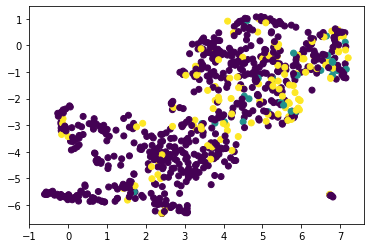

In [44]:
import umap.umap_ as umap


reducer = umap.UMAP()
embedding = reducer.fit_transform(data_np.reshape((data_np.shape[0], data_np.shape[1]*data_np.shape[2])))
plt.scatter(embedding[:,0], embedding[:,1], c =numeric_image_labels )

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.484s...
[t-SNE] Computed neighbors for 800 samples in 34.599s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 11.012527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.175934
[t-SNE] KL divergence after 300 iterations: 1.309496


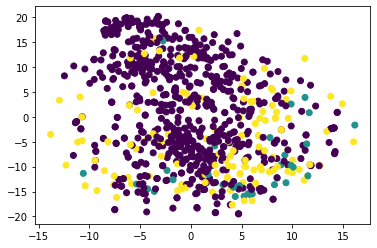

In [48]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_np.reshape(
    (data_np.shape[0], data_np.shape[1]*data_np.shape[2])))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c =numeric_image_labels )

### Morphological edge detection
Due to the nature of the images and id cards having a very specific rectangular form I have decided to explore the option of morphological egde detection as a way to extract information from the data.

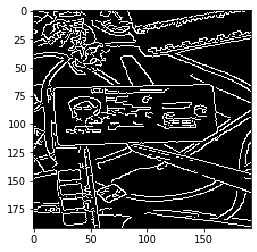

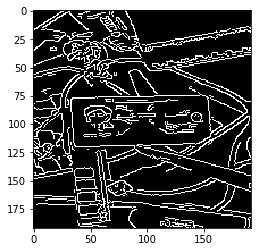

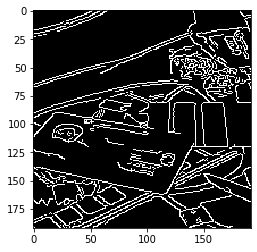

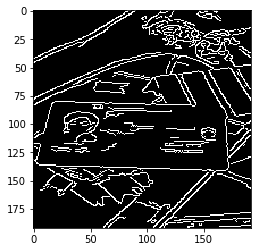

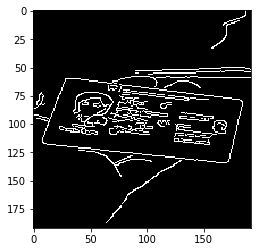

In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

for img in all_images[:5]:
    edges = cv2.Canny(img,100,200)
    plt.imshow(edges,cmap = 'gray')
    plt.show()